# Importing the Required Libraries

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Loading Images from the Disk

In [32]:
# Global Variables for later use

IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

In [33]:
# function that would read an image provided the image path, preprocess and return it back

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) # resizing it to 128*128
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [34]:
labels = ['real', 'fake']

X = [] # To store images
y = [] # To store labels

# labels -
# 0 - Real
# 1 - Fake
image_path = r"C:\Users\Hp\Downloads\dataset" # path containing image samples

In [35]:
image_path = 'C:/Users/Hp/Downloads/dataset/'

for folder in os.scandir(image_path):
    if not folder.is_dir():
        continue  # Skip if the current entry is not a directory
    
    for entry in os.scandir(image_path + folder.name):
        if not entry.is_file():
            continue  # Skip if the current entry is not a file
        
        X.append(read_and_preprocess(image_path + folder.name + '/' + entry.name))
        
        if folder.name[0] == 'r':
            y.append(0)  # real
        else:
            y.append(1)  # fake


In [36]:
X = np.array(X)
X.shape # We have 1289 image samples in total

(1289, 128, 128, 3)

In [37]:
y = np.array(y)
y.shape

(1289,)

# Exploring the Dataset

<BarContainer object of 2 artists>

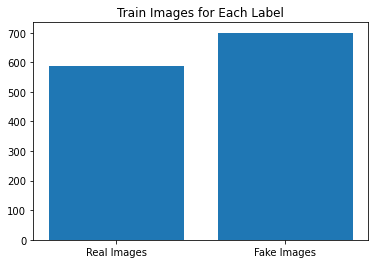

In [38]:
real_count = len(y[y==0])
fake_count = len(y[y==1])

plt.title("Train Images for Each Label")
plt.bar(["Real Images", "Fake Images"],[real_count, fake_count])

# We have more samples of Fake Images than Real Images

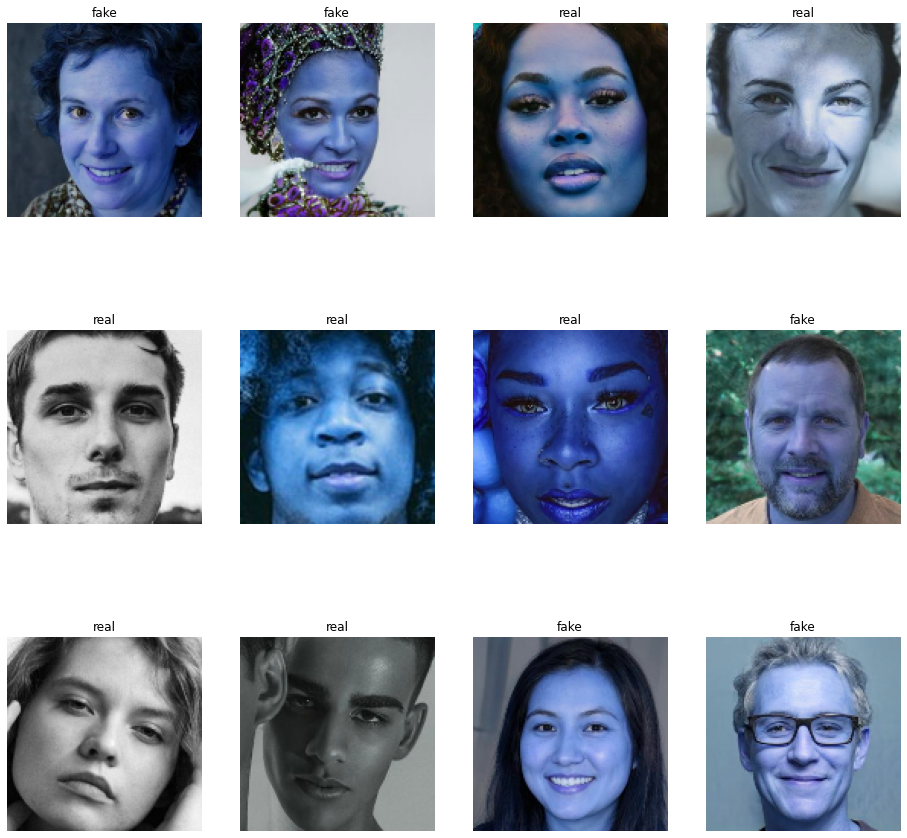

In [39]:
# plotting random images

import random

plt.figure(figsize=(16, 16))

for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.axis("off")
    img = random.randint(0, 1289)
    plt.imshow(X[img])
    plt.title(labels[y[img]])

# Splitting the dataset
### We will take -

#### 80% data for training our model
#### 10% data for validation purpose
#### 10% data for test purpose

In [40]:
from sklearn.model_selection import train_test_split

# We have splitted our data in a way that - 
# 1. The samples are shuffled
# 2. The ratio of each class is maintained (stratify)
# 3. We get same samples every time we split our data (random state)

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  shuffle=True, 
                                                  stratify=y, 
                                                  random_state=123)

In [41]:
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, 
                                                  test_size=0.5, 
                                                  shuffle=True, 
                                                  stratify=y_val, 
                                                  random_state=123)

In [42]:
# we are using 1031 images for training our model
X_train.shape

(1031, 128, 128, 3)

In [43]:
# we are using 129 images for validating our model
X_val.shape

(129, 128, 128, 3)

In [44]:
# we are using 129 images for testing our model
X_test.shape

(129, 128, 128, 3)

In [45]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape),
    MaxPooling2D((4,4)),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((3,3)),
    Dropout(0.3), # for regularization
    
    Conv2D(filters=64, kernel_size=(4,4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    
    Flatten(), # flattening for feeding into ANN
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [46]:
# There are 1.1 Million Traininable Parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 127, 127, 32)      416       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 10, 10, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 64)       

In [47]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [48]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="fakevsreal_weights.h5", verbose=1, save_best_only=True)

In [49]:
history = model.fit(X_train, y_train, epochs = 50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True,  callbacks=[earlystopping, checkpointer])

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.5228
Epoch 1: val_loss improved from inf to 0.69200, saving model to fakevsreal_weights.h5
33/33 [==============================] - 12s 326ms/step - loss: 0.6972 - accuracy: 0.5228 - val_loss: 0.6920 - val_accuracy: 0.5426
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5325
Epoch 2: val_loss improved from 0.69200 to 0.68990, saving model to fakevsreal_weights.h5
33/33 [==============================] - 8s 231ms/step - loss: 0.6928 - accuracy: 0.5325 - val_loss: 0.6899 - val_accuracy: 0.5426
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5432
Epoch 3: val_loss improved from 0.68990 to 0.68900, saving model to fakevsreal_weights.h5
33/33 [==============================] - 8s 249ms/step - loss: 0.6902 - accuracy: 0.5432 - val_loss: 0.6890 - val_accuracy: 0.5426
Epoch 4/50
33/33 [==============================] - ETA: 0

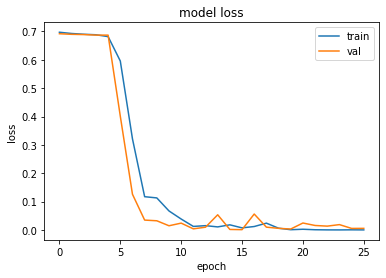

In [60]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

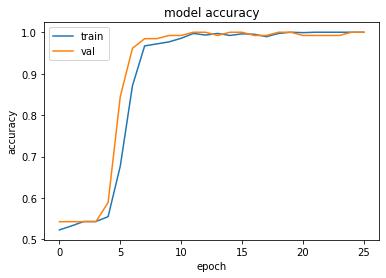

In [61]:
# The is how training accuracy and validation accuracy varied during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [62]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("fakevsreal_model.json","w") as json_file:
  json_file.write(model_json)

# Evaluating the Saved Model Performance

In [63]:
# Load pretrained model (best saved one)
with open('fakevsreal_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model weights  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('fakevsreal_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [64]:
# making predictions
predictions = model.predict(X_test)

5/5 [==============================] - 0s 54ms/step


In [65]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [66]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

1.0

<AxesSubplot:>

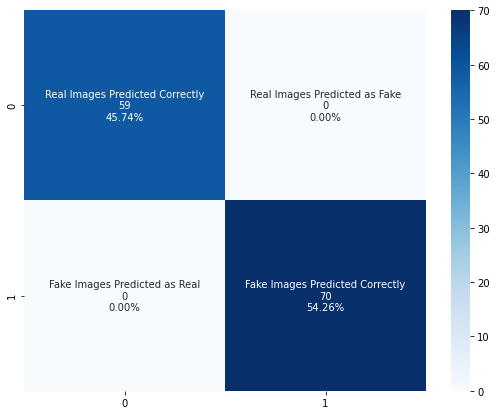

In [67]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predict)
plt.figure(figsize = (9,7))

group_names = ['Real Images Predicted Correctly','Real Images Predicted as Fake','Fake Images Predicted as Real','Fake Images Predicted Correctly']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [68]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        70

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



In [59]:
# Save the model architecture to JSON
model_json = model.to_json()
with open('fakevsreal_model.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights('fakevsreal_weights.h5')